In [ ]:
import pandas as pd
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import activations


In [ ]:
from google.colab import drive

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!ls "/gdrive/My Drive/Proj2_data/data1"

label_names.csv  test.pickle  train.pickle  valid.pickle


In [ ]:
sign_names = pd.read_csv('/gdrive/My Drive/Proj2_data/data1/label_names.csv')
sign_names.head(10)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [ ]:
classID_signames = list(sign_names['SignName'])
len(classID_signames)

43

In [ ]:
train = pd.read_pickle('/gdrive/My Drive/Proj2_data/data1/train.pickle')
#train

In [ ]:
test = pd.read_pickle('/gdrive/My Drive/Proj2_data/data1/test.pickle')
#test

In [ ]:
valid = pd.read_pickle('/gdrive/My Drive/Proj2_data/data1/valid.pickle')
#valid

In [ ]:
train['features'].shape

(34799, 32, 32, 3)

In [ ]:
X_train = train['features']

In [ ]:
labels = train['labels']
labels.shape
y_train = labels
y_train.shape

(34799,)

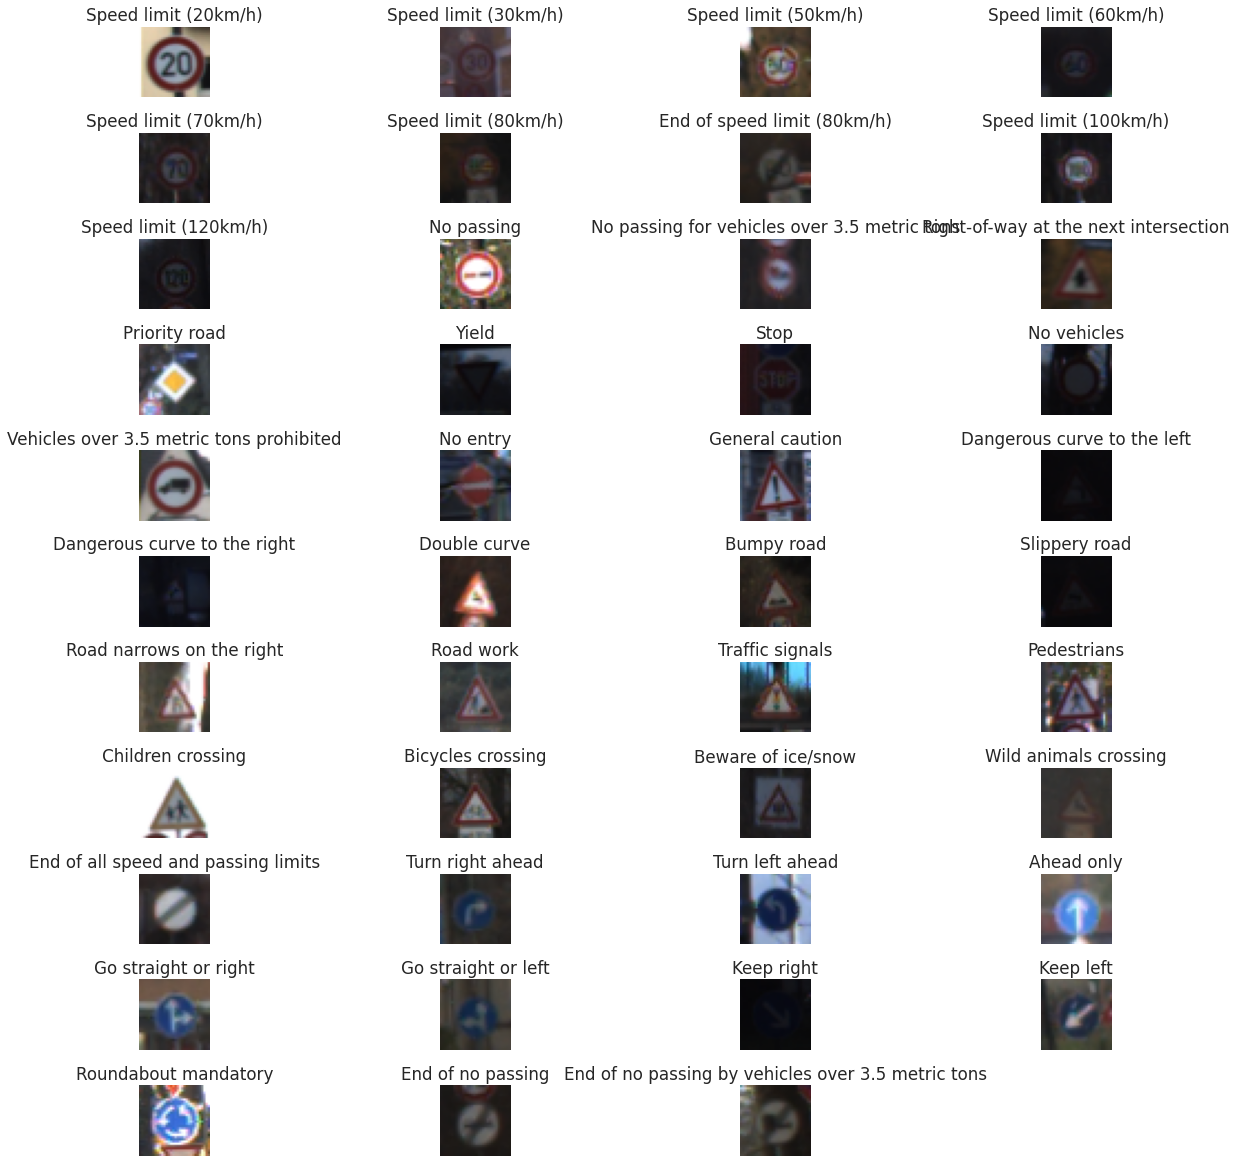

In [ ]:
train_unique_indexs = list(np.unique(y_train, return_index=True)[1])
rows = len(train_unique_indexs)//4 + 1
f = plt.figure(figsize=(20, 16))
for i, index in enumerate(train_unique_indexs, 1):
    plt.subplot(rows, 4, i)
    plt.imshow(X_train[train_unique_indexs[i-1]])
    plt.axis('off')
    plt.title(classID_signames[i-1])
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

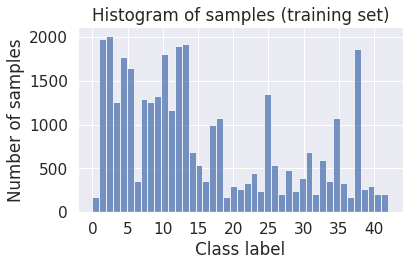

In [ ]:
# build a histogram of the training dataset
fig, ax = plt.subplots()
n_bins = 43
n_train, bins, patches = ax.hist(y_train, n_bins, histtype='bar', facecolor='b', alpha=0.75)
ax.set_xlabel('Class label')
ax.set_ylabel('Number of samples')
ax.set_title('Histogram of samples (training set)')
ax.set_xticks(np.arange(0,n_bins-1,5))
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
label_nums=[]
for i in range(43):
    label_nums.append(0)
    for j in range(len(y_train)):
        if(i == y_train[j]):
            label_nums[i]+=1
for i in range(43):
    print(label_nums[i])
print("min is :",min(label_nums))
print("max is  :",max(label_nums))

180
1980
2010
1260
1770
1650
360
1290
1260
1320
1800
1170
1890
1920
690
540
360
990
1080
180
300
270
330
450
240
1350
540
210
480
240
390
690
210
599
360
1080
330
180
1860
270
300
210
210
min is : 180
max is  : 2010


In [ ]:
#grayscale_histogram_equalize_normalize for training_set
import cv2

X_train = X_train.astype('float32')

temp = []
for i in X_train:
  gray = cv2.cvtColor(i , cv2.COLOR_RGB2GRAY)

  eq = cv2.equalizeHist(np.uint8(gray))
  temp.append(eq.reshape(32,32,1))

X_train = np.array(temp)

X_train = X_train / 255.0

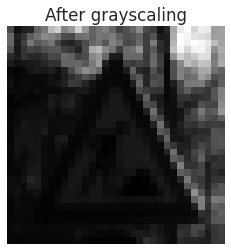

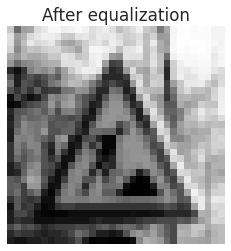

In [ ]:
plt.figure(1)
plt.imshow(gray,cmap='gray')
plt.title('After grayscaling')
plt.axis('off');

plt.figure(2)
plt.imshow(eq,cmap='gray')
plt.title('After equalization')
plt.axis('off');


In [ ]:
X_train.shape

(34799, 32, 32, 1)

In [ ]:
y_train = to_categorical(y_train)

In [ ]:
y_train.shape

(34799, 43)

In [ ]:
#Augmentation parameters

"""aug_datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range = 0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        )

#using .flow instead of .fit to write to an array
augmented_data = []
augmented_labels=[]
num_augmented = 0

batch = 5 # for 10*10 = 100 entries
for X_batch, y_batch in aug_datagen.flow(X_train, y_train, batch_size=batch, shuffle=True):
    augmented_data.append(X_batch)
    augmented_labels.append(y_batch)
    num_augmented += 1
    if num_augmented == X_batch.shape[0]:
        break
augmented_data = np.concatenate(augmented_data)
augmented_labels = np.concatenate(augmented_labels)


#Lets take a look at augmented images
for index, image in enumerate(augmented_data):
    plt.subplot(5, 5, index + 1)
    plt.imshow(np.reshape(image, (32,32)), cmap=plt.cm.gray)
"""

'aug_datagen = ImageDataGenerator(  \n        rotation_range=30,   \n        zoom_range = 0.2,  \n        width_shift_range=0.2,  \n        height_shift_range=0.2,  \n        )  \n\n#using .flow instead of .fit to write to an array\naugmented_data = []\naugmented_labels=[]\nnum_augmented = 0\n\nbatch = 5 # for 10*10 = 100 entries\nfor X_batch, y_batch in aug_datagen.flow(X_train, y_train, batch_size=batch, shuffle=True):\n    augmented_data.append(X_batch)\n    augmented_labels.append(y_batch)\n    num_augmented += 1\n    if num_augmented == X_batch.shape[0]:\n        break\naugmented_data = np.concatenate(augmented_data) \naugmented_labels = np.concatenate(augmented_labels)\n\n\n#Lets take a look at augmented images\nfor index, image in enumerate(augmented_data):\n    plt.subplot(5, 5, index + 1)\n    plt.imshow(np.reshape(image, (32,32)), cmap=plt.cm.gray)\n'

In [ ]:
#augmented_data.shape

In [ ]:
#augmented_data

In [ ]:
#X_train = np.concatenate((X_train, augmented_data), axis = 0)

In [ ]:
#X_train.shape

In [ ]:
#y_train = np.concatenate((y_train , augmented_labels), axis = 0)

In [ ]:
#y_train.shape

In [ ]:
X_valid = valid['features']

In [ ]:
valid_labels = valid['labels']
#valid_labels.shape
y_valid = valid_labels

y_valid = to_categorical(y_valid)

In [ ]:
y_valid.shape

(4410, 43)

In [ ]:
#grayscale_histogram_equalize_normalize for validation

X_valid = X_valid.astype('float32')
val = []
for i in X_valid:
  gray = cv2.cvtColor(i , cv2.COLOR_RGB2GRAY)
  eq = cv2.equalizeHist(np.uint8(gray))
  val.append(eq.reshape(32,32,1))

X_valid = np.array(val)

X_valid = X_valid / 255.0

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,# randomly flip images
      )
type(datagen)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

In [ ]:
batch_size = 128
image_data = datagen.flow(X_train,
                             y=y_train,
                            batch_size = batch_size)

for i,(images,labels) in enumerate(image_data):
  print(i)
  if i == 0:
    print(images.shape)
    break

0
(128, 32, 32, 1)


0
(1, 32, 32, 1)
(32, 32, 1)
(32, 32)


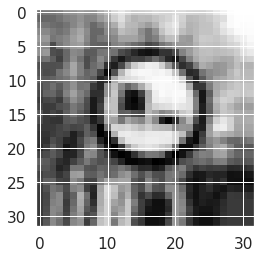

In [ ]:
batch_size = 1
image_data = datagen.flow(X_train,
                            batch_size = batch_size)

for i,(images) in enumerate(image_data):
  print(i)
  if i == 0:
    print(images.shape)
    img = images[0]
    print(img.shape)
    img = img.reshape(32,32)
    #img = img.reshape(32,32,3)
    print(img.shape)
    plt.imshow(img, cmap='gray')
    break


0
(1, 32, 32, 1)
(32, 32, 1)
(32, 32)
label : [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


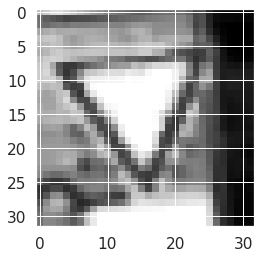

In [ ]:
batch_size = 1
image_data = datagen.flow(X_train,
                             y=y_train,
                            batch_size = batch_size)

for i,(images,labels) in enumerate(image_data):
  print(i)
  if i == 0:
    print(images.shape)
    img = images[0]
    print(img.shape)
    img = img.reshape(32,32)
    #img = img.reshape(32,32,3)
    print(img.shape)
    plt.imshow(img, cmap='gray')
    print('label : {}'.format(labels))
    break

In [ ]:
batch_size = 256
Training_data = datagen.flow(X_train,
                             y=y_train,
                            batch_size = batch_size)

Validation_data = datagen.flow(X_valid,
                             y=y_valid,
                            batch_size = batch_size)



In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=1)

In [ ]:
input_model = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name = 'input_layer')

model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_5')(input_model)
model1 = BatchNormalization(name = 'Bnorm1')(model1)
model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv2_5')(model1)
model1 = BatchNormalization(name = 'Bnorm2')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv3_3')(model1)
model1 = BatchNormalization(name = 'Bnorm3')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv4_3')(model1)
model1 = BatchNormalization(name = 'Bnorm4')(model1)
model1 = AveragePooling2D((2, 2),name = 'AvgPool1')(model1)
model1 = Conv2D(128,(2,2), activation='relu' ,padding='valid',name = 'Conv5_1')(model1)
model1 = BatchNormalization(name = 'Bnorm5')(model1)
########################################################
model1 = Flatten(name = 'Flatten')(model1)
########################################################
model1 = Dense(units = 32, activation = 'relu')(model1)
model1 = Dropout(rate = 0.2)(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 20, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 15, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
output = Dense(units = 43, activation = 'softmax' , name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "functional_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
Conv1_5 (Conv2D)             (None, 28, 28, 32)        832       
_________________________________________________________________
Bnorm1 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
Conv2_5 (Conv2D)             (None, 28, 28, 32)        25632     
_________________________________________________________________
Bnorm2 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
Conv3_3 (Conv2D)             (None, 14, 14, 64)      

In [ ]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(Training_data,
                              epochs= 15,
                              validation_data=Validation_data,
                              verbose=1,
                              callbacks=[es])

Epoch 1/15
136/136 [==============================] - 10s 72ms/step - loss: 2.9240 - accuracy: 0.2639 - val_loss: 3.8556 - val_accuracy: 0.0596
Epoch 2/15
136/136 [==============================] - 10s 71ms/step - loss: 1.6106 - accuracy: 0.5492 - val_loss: 2.1038 - val_accuracy: 0.4293
Epoch 3/15
136/136 [==============================] - 10s 71ms/step - loss: 1.0018 - accuracy: 0.7175 - val_loss: 1.0164 - val_accuracy: 0.7177
Epoch 4/15
136/136 [==============================] - 9s 69ms/step - loss: 0.6622 - accuracy: 0.8131 - val_loss: 0.6200 - val_accuracy: 0.8184
Epoch 5/15
136/136 [==============================] - 9s 70ms/step - loss: 0.4801 - accuracy: 0.8634 - val_loss: 0.5045 - val_accuracy: 0.8553
Epoch 6/15
136/136 [==============================] - 9s 69ms/step - loss: 0.3702 - accuracy: 0.8923 - val_loss: 0.2970 - val_accuracy: 0.9075
Epoch 7/15
136/136 [==============================] - 9s 69ms/step - loss: 0.2916 - accuracy: 0.9162 - val_loss: 0.2537 - val_accuracy: 0.9

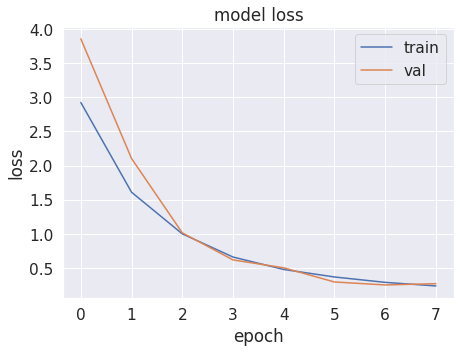

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

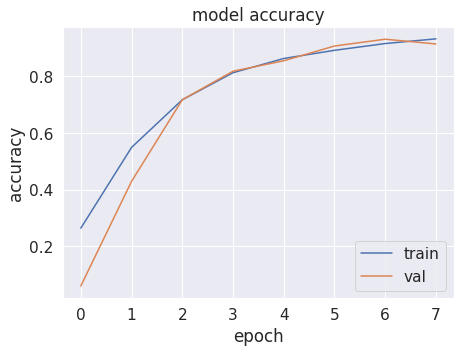

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (7,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
model.save_weights("/gdrive/My Drive/network_best_weights.hdf5")
model.save("/gdrive/My Drive/network_best.hdf5")

In [ ]:
valid = model.predict(X_valid)
valid_score = len(y_valid[y_valid.argmax(axis=1)==valid.argmax(axis=1)])/len(y_valid)
print(f"Validation Score = {valid_score*100:0.2f}%")

Validation Score = 95.24%


In [ ]:
X_test = test['features']
X_test = X_test.astype('float32')
temp = []
for i in X_test:
  gray = cv2.cvtColor(i , cv2.COLOR_RGB2GRAY)
  eq = cv2.equalizeHist(np.uint8(gray))
  temp.append(eq.reshape(32,32,1))

X_test = np.array(temp)

X_test = X_test / 255.0
X_test.shape

(12630, 32, 32, 1)

In [ ]:
y_test = test['labels']
y_test= to_categorical(y_test)
#np.random.shuffle(y_test)

In [ ]:
y_test_predict = model.predict(X_test)
test_score = len(y_test[y_test.argmax(axis=1)==y_test_predict.argmax(axis=1)])/len(y_test)
print(f"Test Score = {test_score*100:0.2f}%")

Test Score = 93.50%


In [ ]:
"""f = plt.figure(figsize=(20, 16))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=1
    """

"f = plt.figure(figsize=(20, 16))\nfor i in range(10):\n    plt.subplot(1, 10, i+1)\n    plt.imshow(X_test[i])\n    plt.axis('off')\n    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=1\n    "

In [ ]:
#np.random.shuffle(X_test)
#np.random.shuffle(y_test)

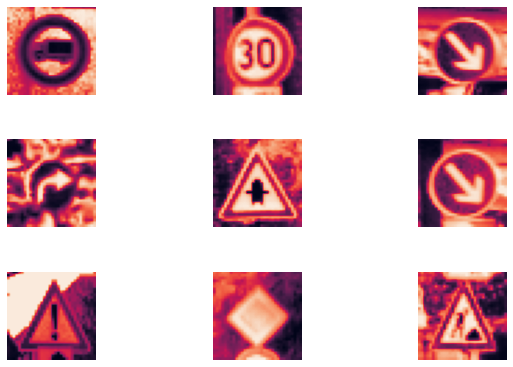

In [ ]:
f = plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i].reshape(32,32))
    plt.axis('off')
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

In [ ]:
predict = model.predict(X_test)
predict

array([[1.0343454e-05, 8.9491186e-07, 3.3111115e-05, ..., 6.2827854e-07,
        4.7775815e-05, 3.9624897e-08],
       [9.3033706e-04, 9.9757129e-01, 4.2963882e-05, ..., 9.1525425e-07,
        3.1400401e-08, 5.8014903e-06],
       [4.9105209e-09, 3.2596065e-05, 4.0093632e-06, ..., 1.5177410e-05,
        9.6675194e-08, 2.0952307e-06],
       ...,
       [8.8417501e-04, 6.6523291e-03, 8.7140100e-03, ..., 4.5555877e-03,
        5.1556383e-03, 3.4415466e-01],
       [7.0990057e-04, 5.8090227e-05, 1.4193512e-04, ..., 4.2529663e-04,
        9.8814894e-07, 6.4536846e-07],
       [3.2679385e-08, 1.8791687e-07, 1.8473711e-05, ..., 3.6884085e-06,
        4.3530545e-06, 1.3307783e-04]], dtype=float32)

In [ ]:
predict_id = predict.argmax(axis=1)
predict_id

array([16,  1, 38, ..., 42,  7, 10])

In [ ]:
#y_test

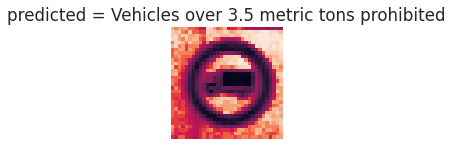

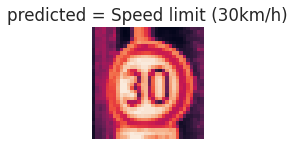

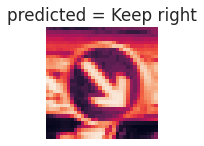

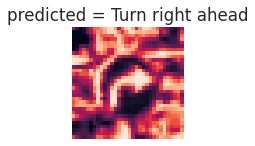

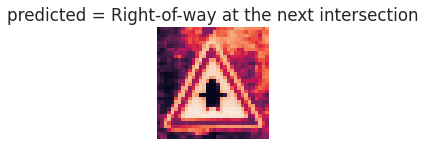

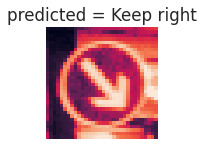

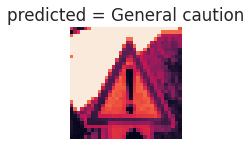

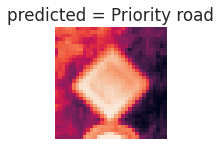

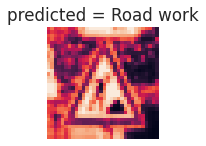

In [ ]:
for i in range(9):
    plt.figure(i, figsize=(2,2))
    plt.imshow(X_test[i].reshape(32,32))
    plt.title(f'predicted = {classID_signames[predict_id[i]]}')
    plt.axis('off')
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_test = test['labels']
print('Confusion Matrix')
print(confusion_matrix(y_test, predict_id))
print('----------------------------')
print('Classification Report')
target_names = classID_signames
print(classification_report(y_test, predict_id, target_names=target_names))

Confusion Matrix
[[ 59   0   0 ...   0   0   0]
 [  0 705  11 ...   0   0   0]
 [  0   3 745 ...   0   0   0]
 ...
 [  2   0   0 ...  75   0   0]
 [  0   0   0 ...   0  51   0]
 [  0   3   2 ...   0   0  63]]
----------------------------
Classification Report
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.95      0.98      0.97        60
                              Speed limit (30km/h)       0.95      0.98      0.96       720
                              Speed limit (50km/h)       0.94      0.99      0.97       750
                              Speed limit (60km/h)       0.98      0.92      0.95       450
                              Speed limit (70km/h)       0.99      0.92      0.95       660
                              Speed limit (80km/h)       0.92      0.93      0.92       630
                       End of speed limit (80km/h)       0.87      0.65      0.74       150
   

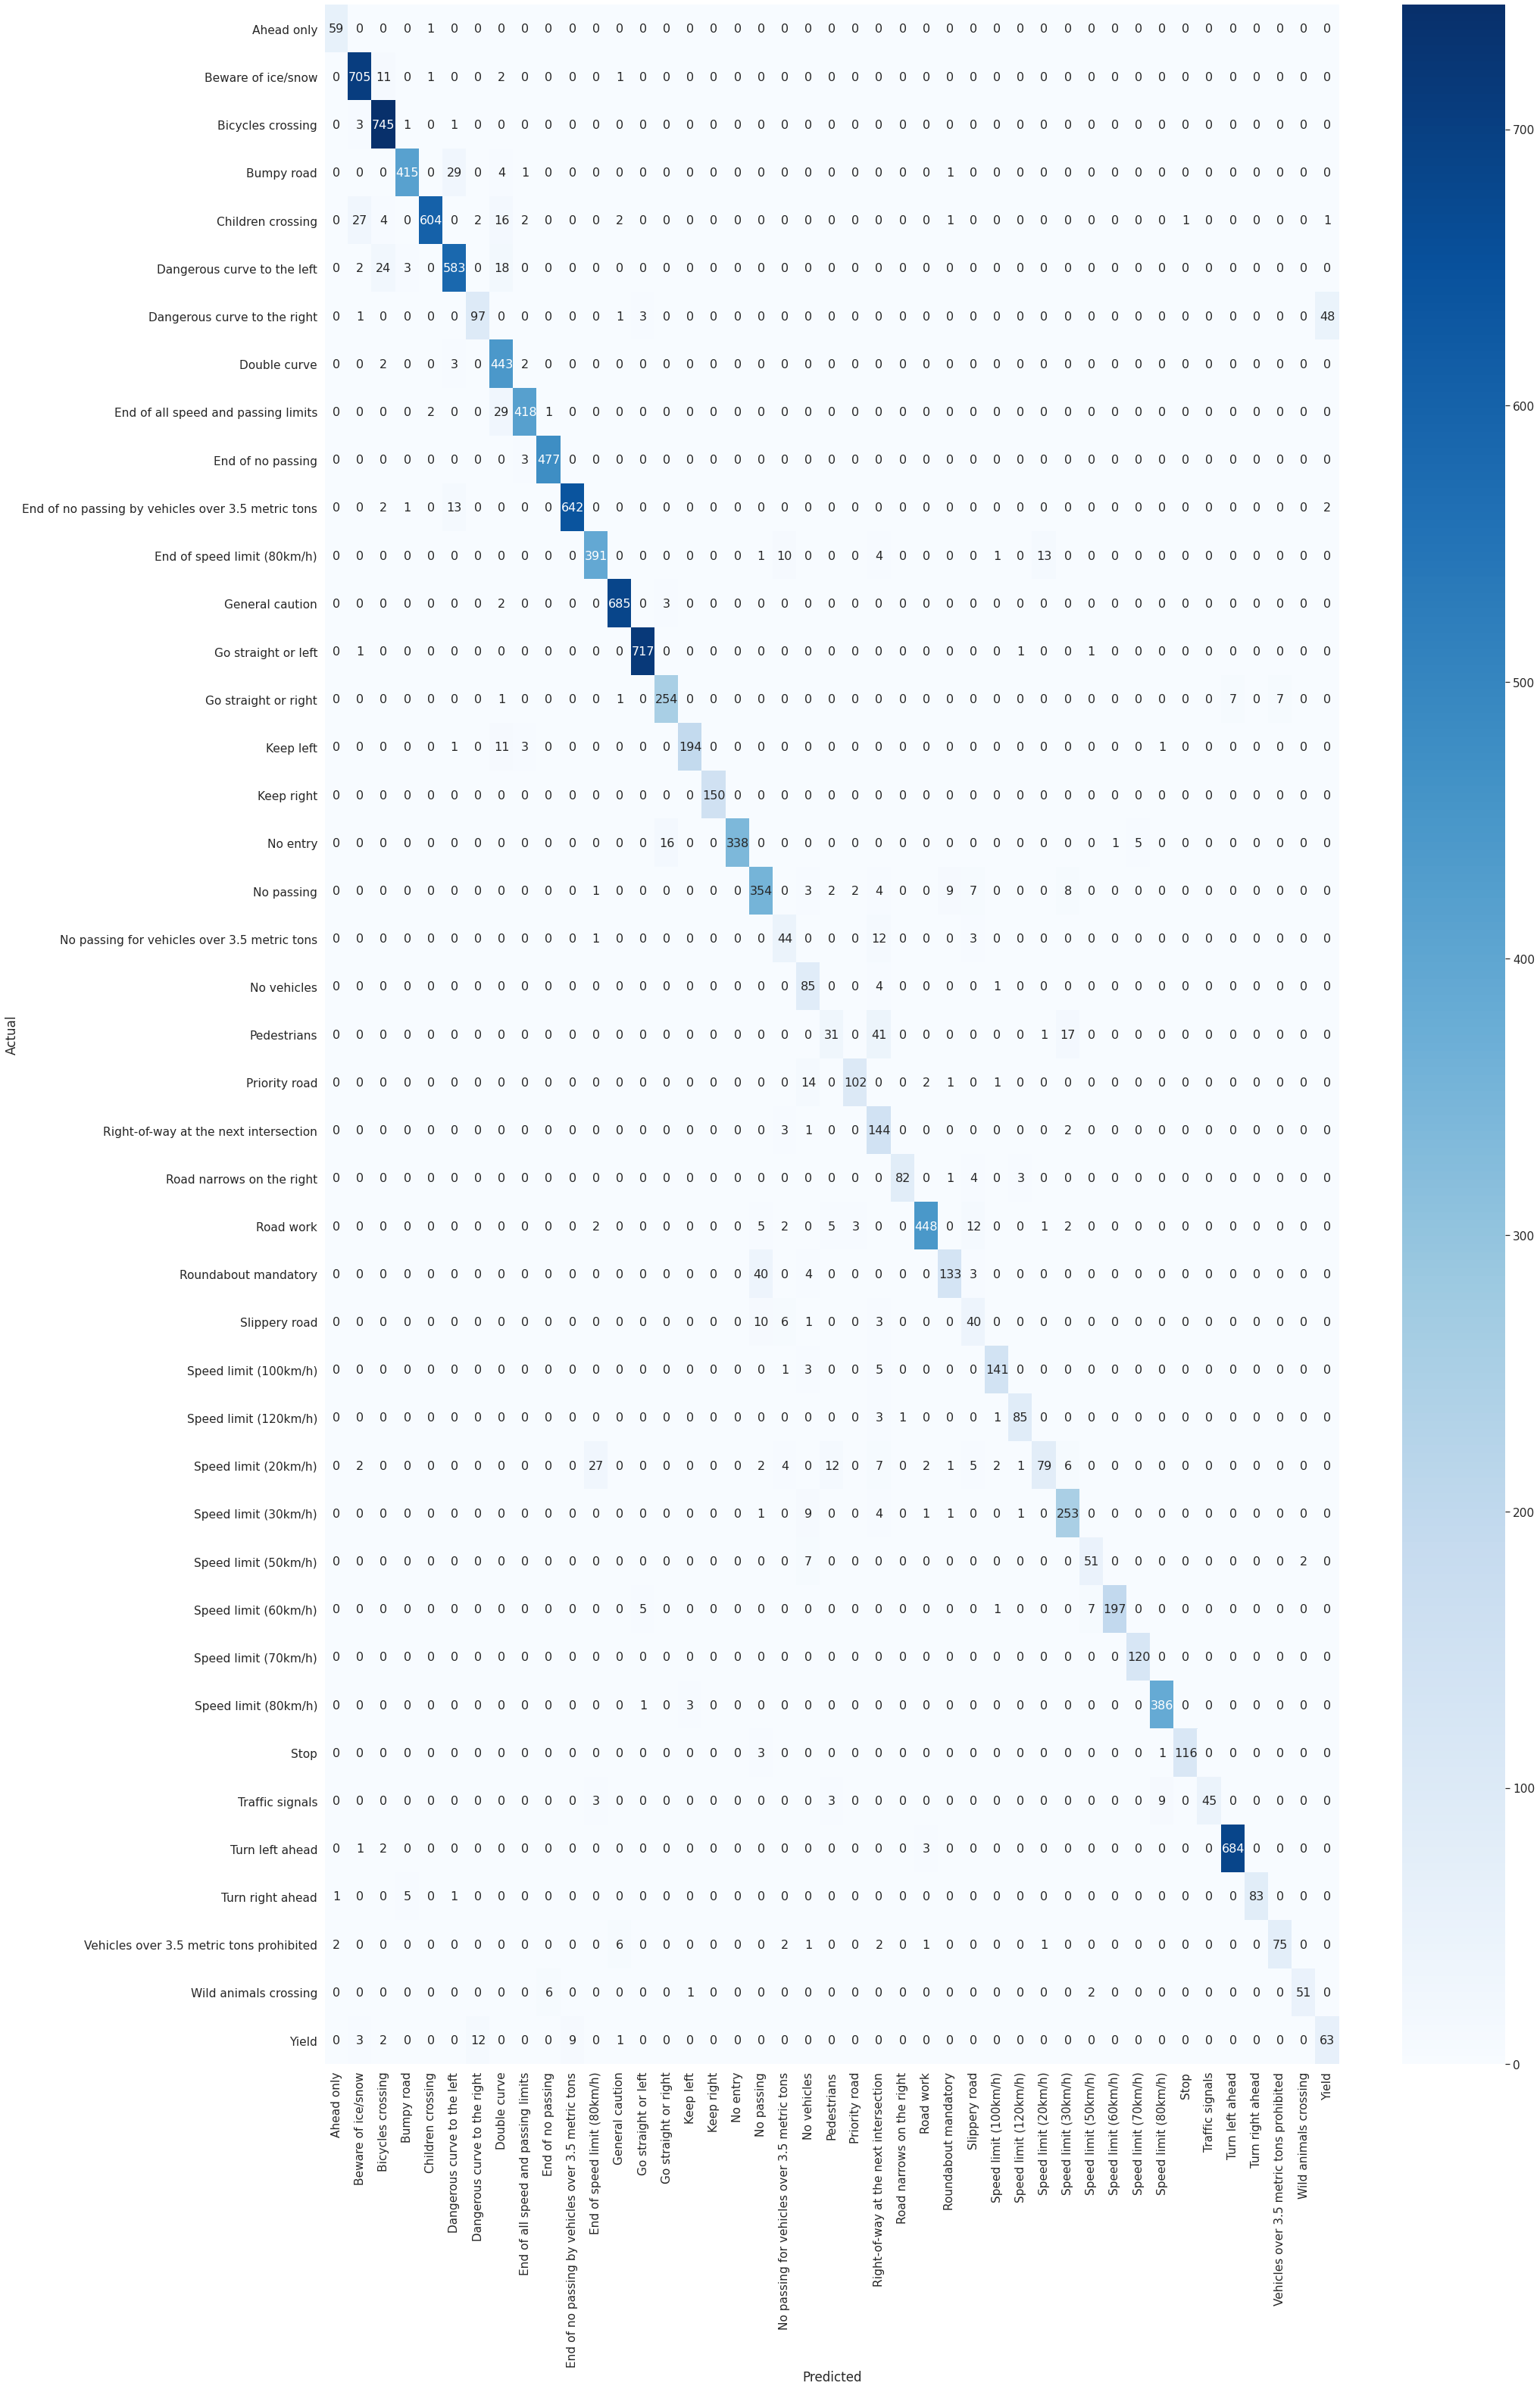

In [ ]:
import seaborn as sns
y_true = classID_signames
y_pred = classID_signames
data = confusion_matrix(y_test, predict_id)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,50))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size

(32, 32, 1)
(32, 32)


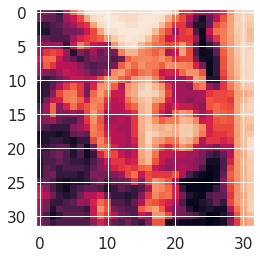

In [ ]:
img = X_train[1000]
print(img.shape)
img = img.reshape(32,32)
print(img.shape)
plt.imshow(img)

In [ ]:
layer_names = []
for layer in model.layers[1:14]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

layer_names

['Conv1_5',
 'Bnorm1',
 'Conv2_5',
 'Bnorm2',
 'MaxPool1',
 'Conv3_3',
 'Bnorm3',
 'Conv4_3',
 'Bnorm4',
 'AvgPool1',
 'Conv5_1',
 'Bnorm5',
 'Flatten']

layer : Conv1_5 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


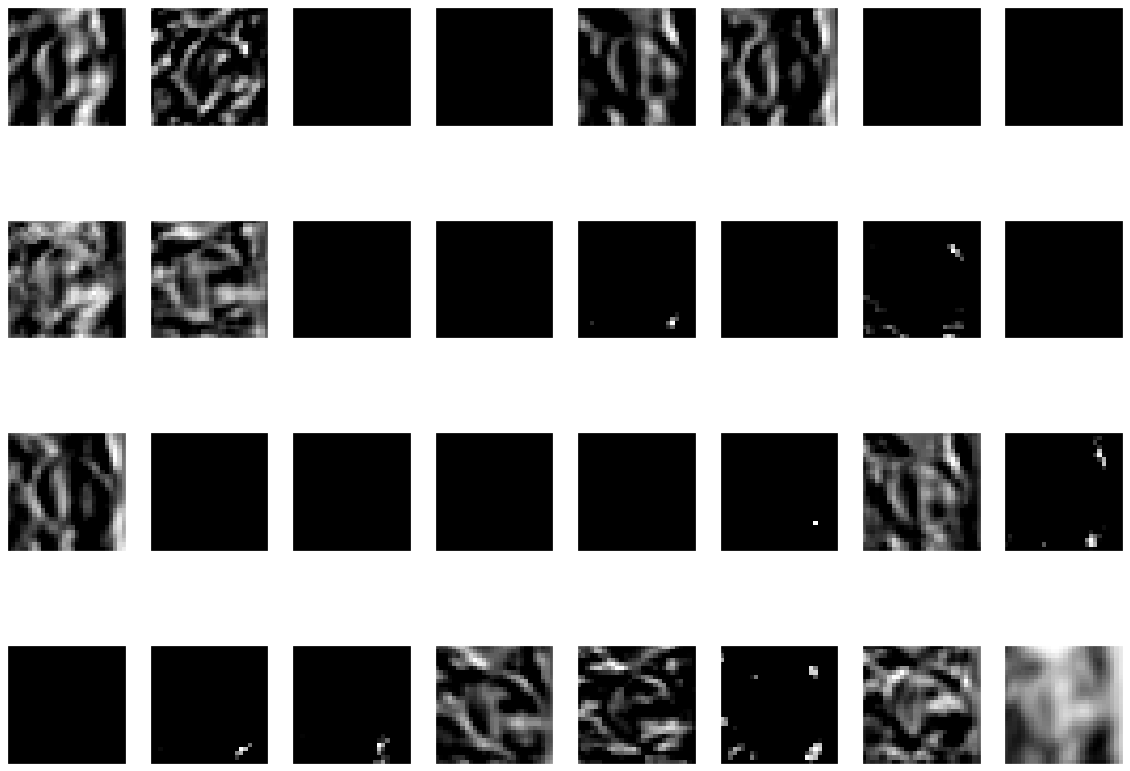

layer : Bnorm1 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


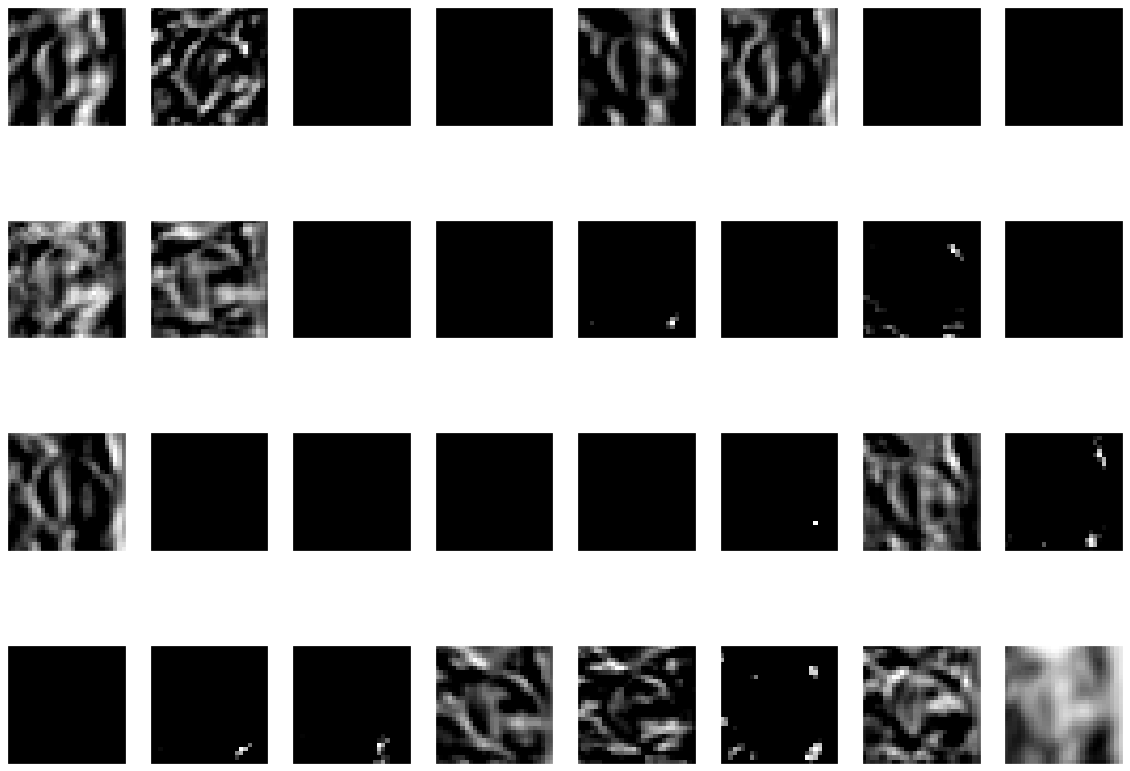

layer : Conv2_5 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


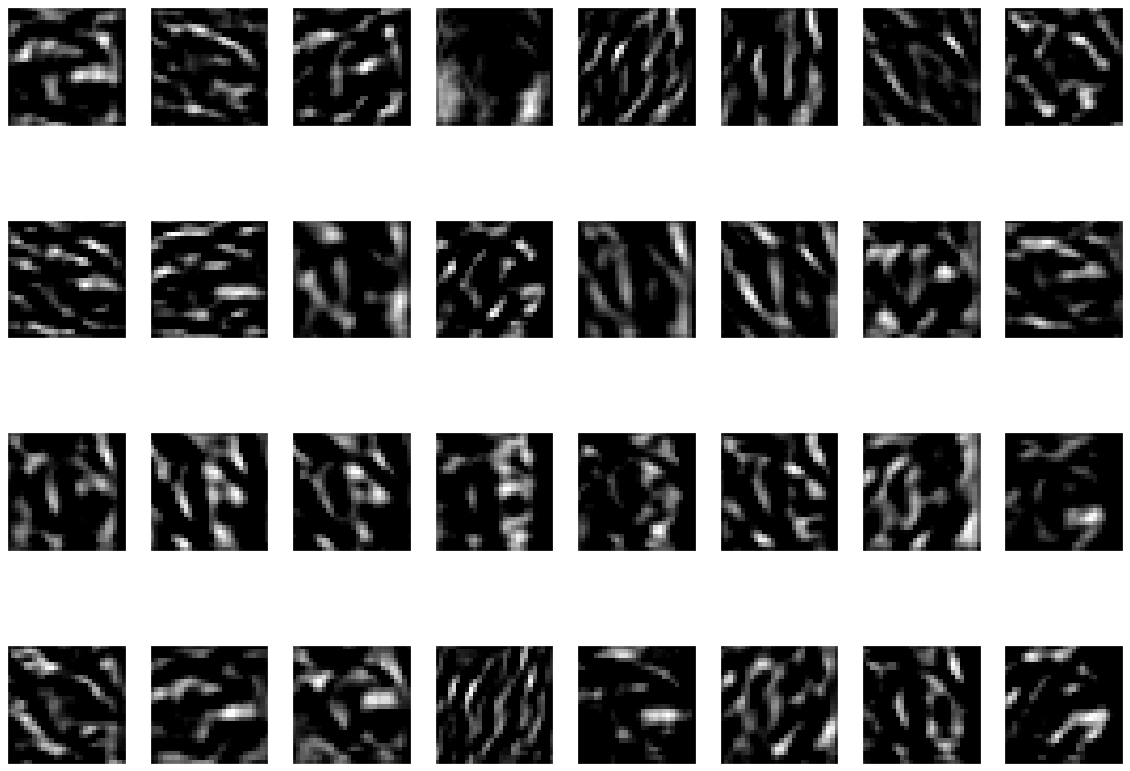

layer : Bnorm2 , feature map shape : (1, 28, 28, 32)
nrow : 4 , ncol : 8


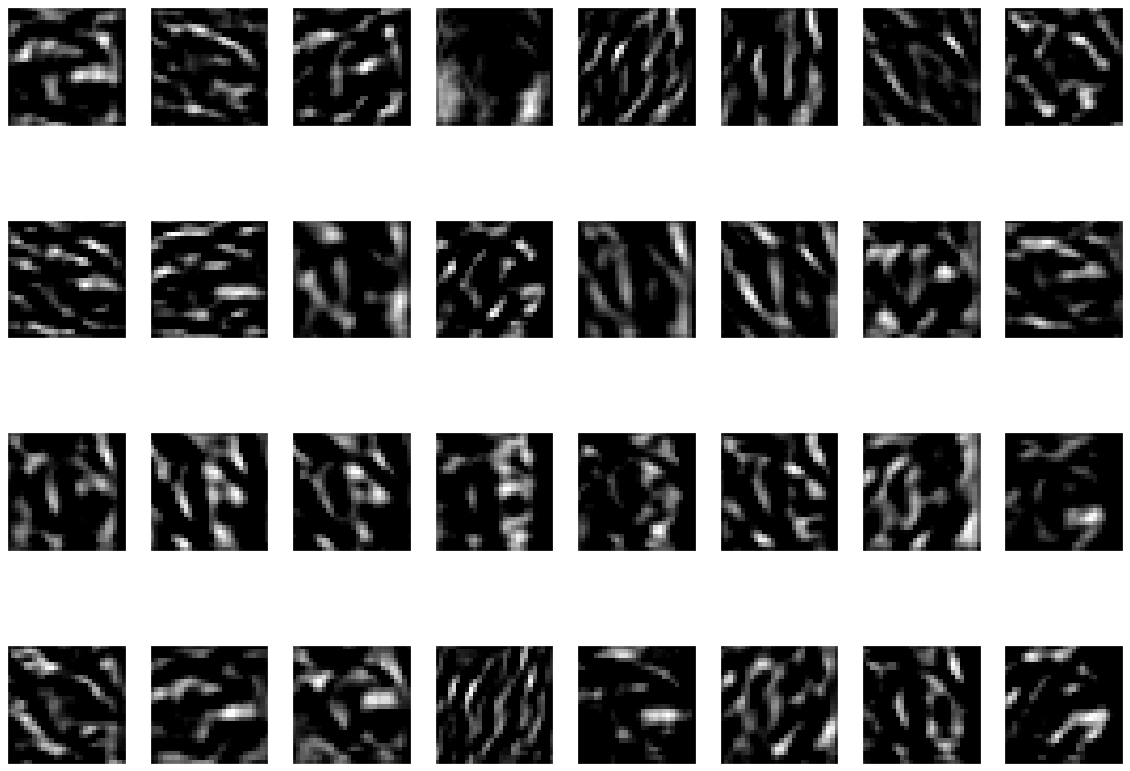

layer : MaxPool1 , feature map shape : (1, 14, 14, 32)
nrow : 4 , ncol : 8


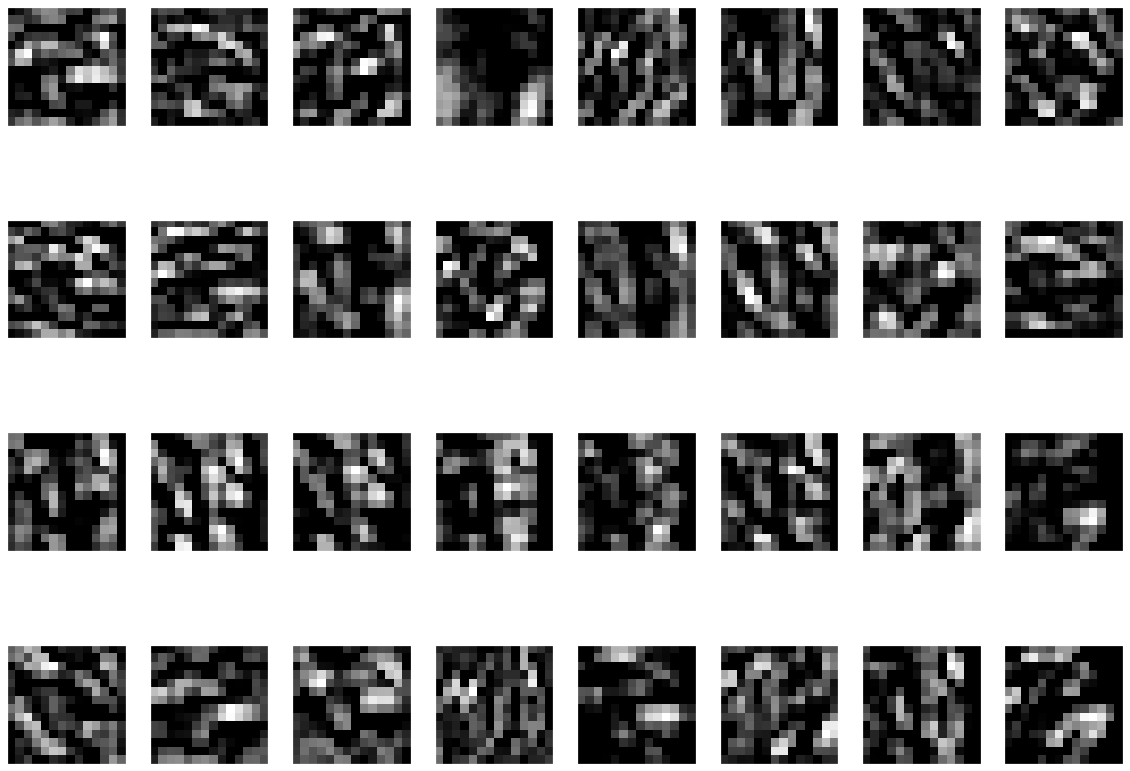

layer : Conv3_3 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


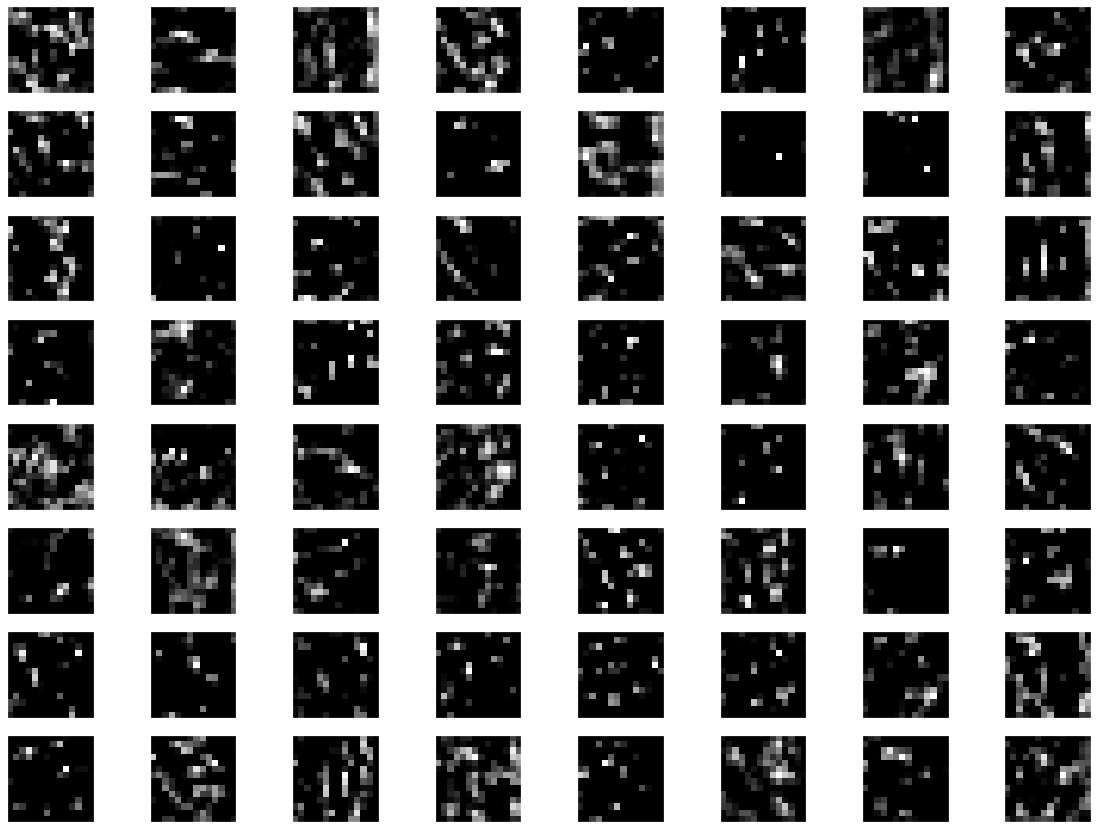

layer : Bnorm3 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


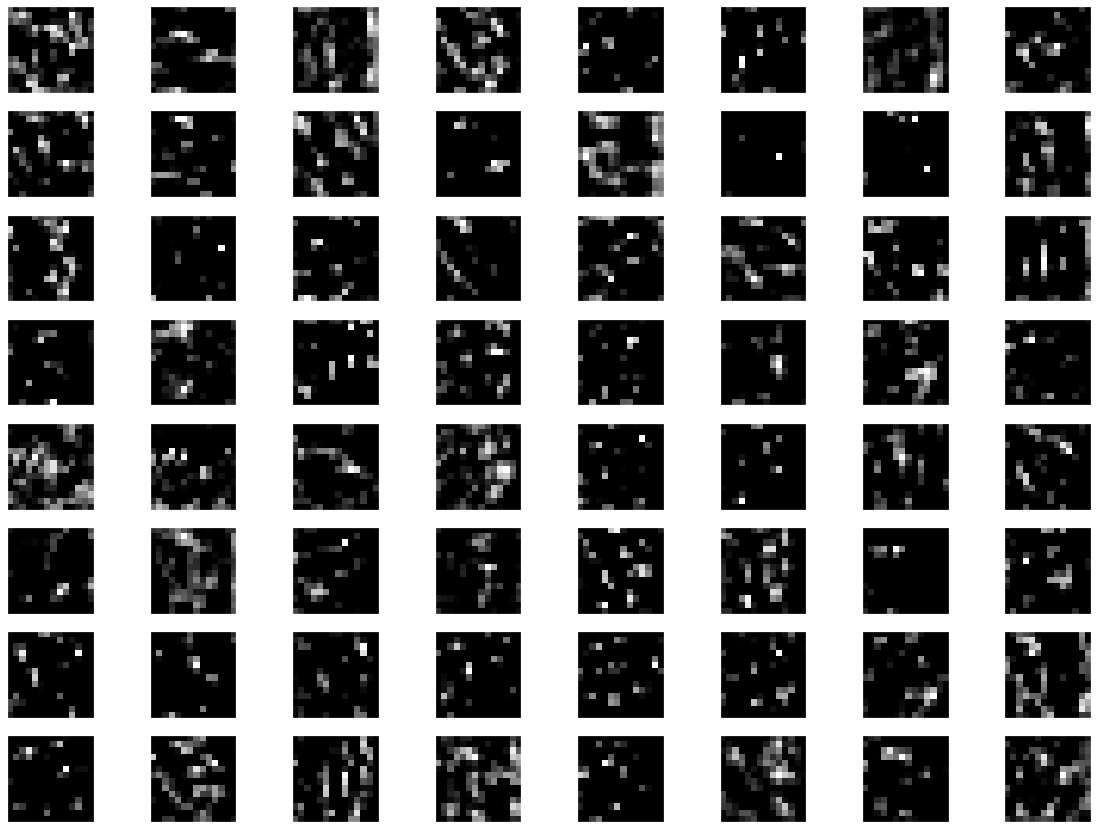

layer : Conv4_3 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


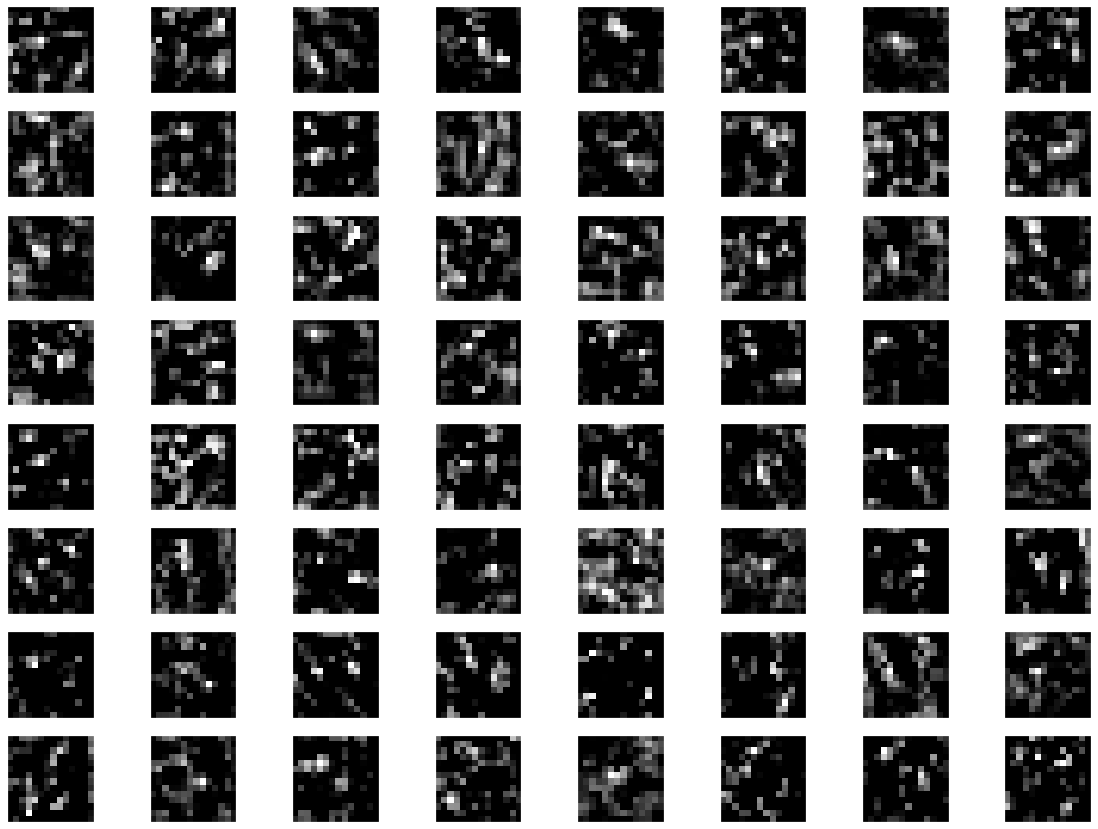

layer : Bnorm4 , feature map shape : (1, 14, 14, 64)
nrow : 8 , ncol : 8


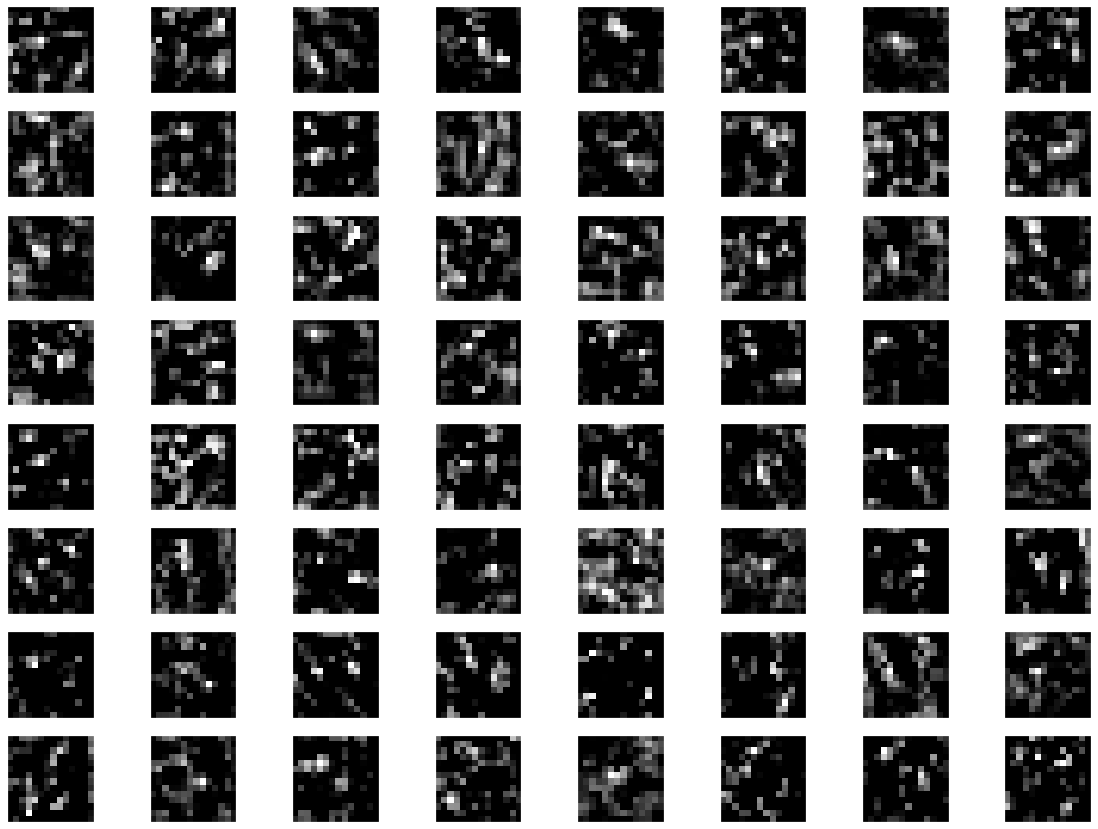

layer : AvgPool1 , feature map shape : (1, 7, 7, 64)
nrow : 8 , ncol : 8


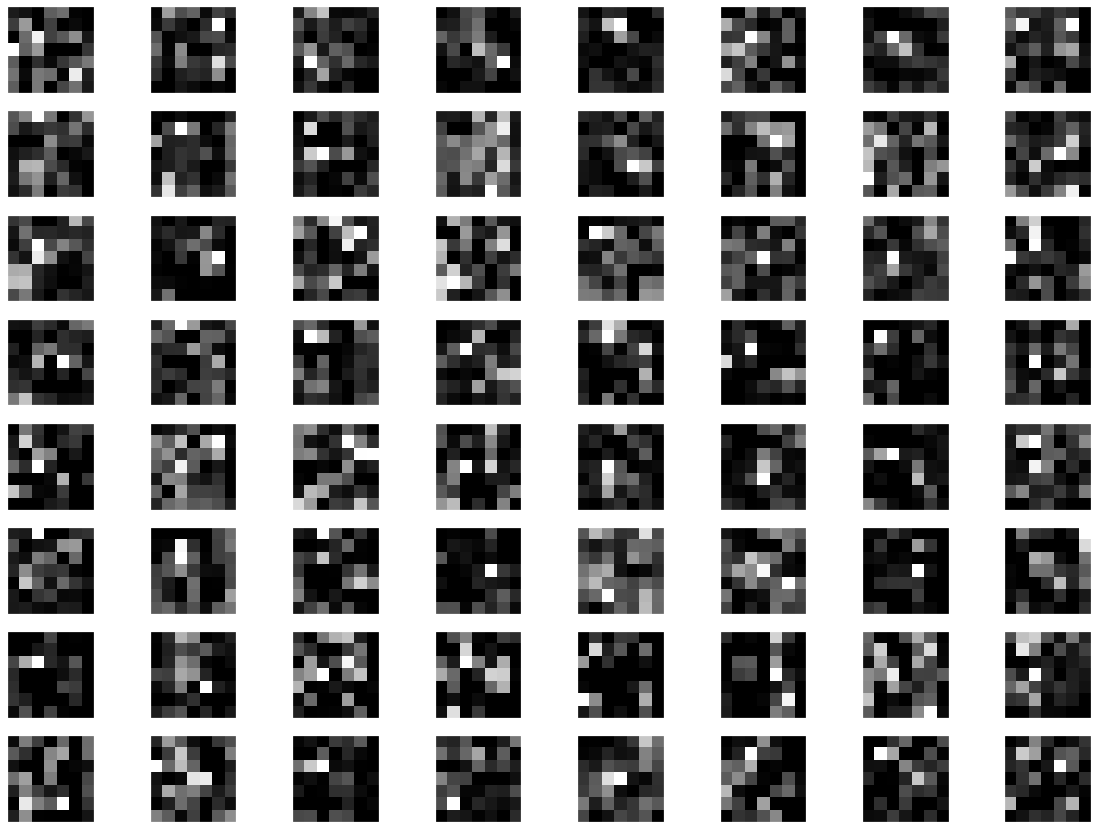

layer : Conv5_1 , feature map shape : (1, 6, 6, 128)
nrow : 16 , ncol : 8


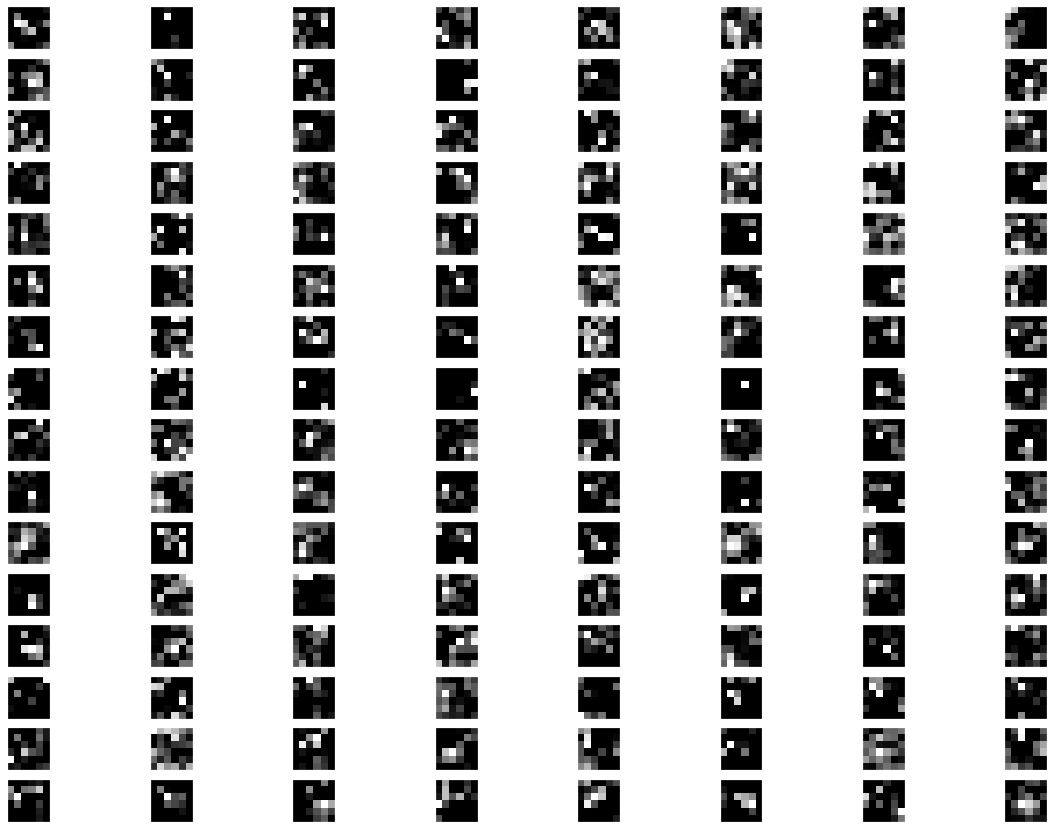

layer : Bnorm5 , feature map shape : (1, 6, 6, 128)
nrow : 16 , ncol : 8


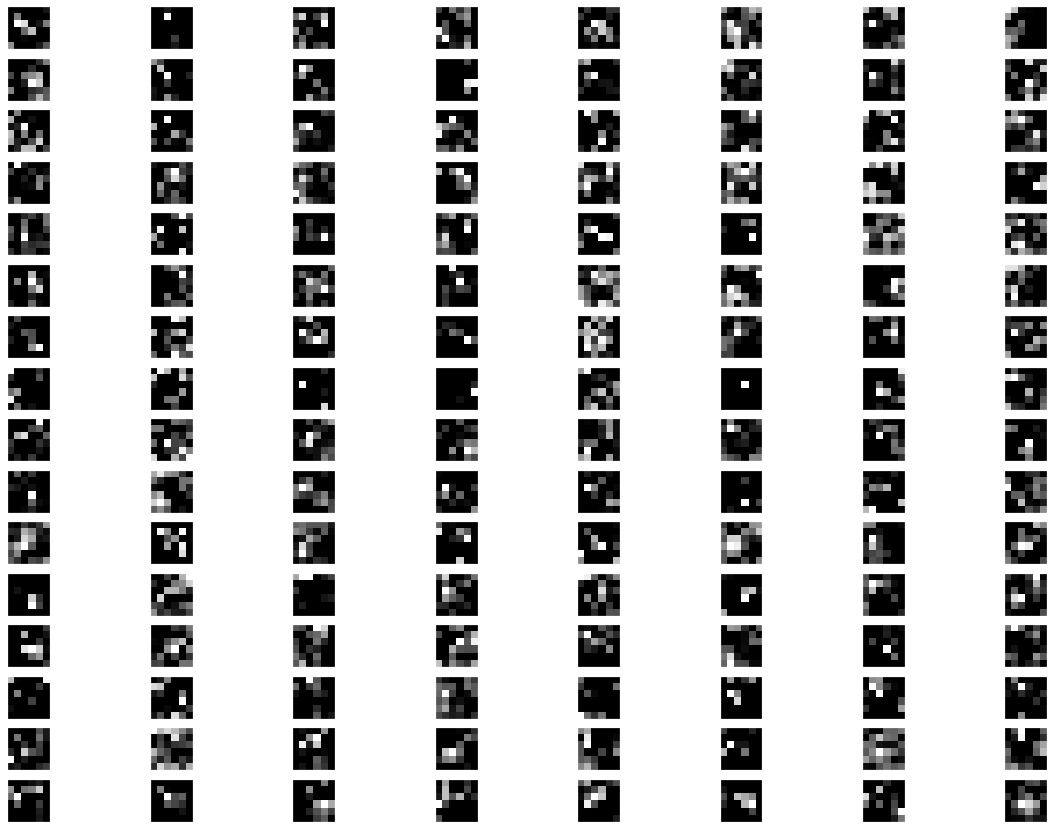

In [ ]:
for n_layer in range(1,13):
  model_layer = Model(inputs=model.inputs, outputs=model.layers[n_layer].output)
  feature_maps = model_layer.predict(X_train[1000].reshape(1,32,32,1))
  print('layer : {} , feature map shape : {}'.format(model.layers[n_layer].name,feature_maps.shape))

  n_row = int(feature_maps.shape[-1]/8)
  n_col = 8
  print('nrow : {} , ncol : {}'.format(n_row,n_col))
  plt.figure(figsize=(20,15))
  # plot all maps in an shape/8 * 8 squares
  ix = 1
  for _ in range(n_row):
	  for _ in range(n_col):
		  # specify subplot and turn of axis
		  ax = plt.subplot(n_row, n_col, ix)
		  ax.set_xticks([])
		  ax.set_yticks([])
		  # plot filter channel in grayscale
		  plt.imshow(feature_maps[0, :, :, ix-1], cmap ='gray')
		  ix += 1
  # show the figure
  plt.show()